<a href="https://colab.research.google.com/github/ishleenkaur256/pfa_project/blob/main/PFA_Final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import urllib.request
import bs4
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import ticker
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
import operator
import nltk
from nltk.stem.porter import PorterStemmer
from sklearn.metrics.pairwise import cosine_similarity
from IPython.display import Image
from sklearn.neighbors import KNeighborsClassifier
import numpy
import random
seed = 42
numpy.random.seed(42)

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from imblearn.under_sampling import RandomUnderSampler

from sklearn import  svm

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import re
from urllib.parse import urljoin
import random


CATEGORIES = {
    "NATIONAL": "https://www.thehindu.com/news/national/",
    "BUSINESS": "https://www.thehindu.com/business/",
    "LIFE-STYLE": "https://www.thehindu.com/life-and-style/",
    "TECHNOLOGY": "https://www.thehindu.com/sci-tech/technology/",
    "EDUCATION": "https://www.thehindu.com/education/",
}
HEADERS = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}
OUTPUT_FILENAME = '/content/drive/MyDrive/PFA_Final_Project/thehindu_dataset.csv'
scraped_articles = []

BASE_DELAY = 1.0
MAX_CONTAINERS_PER_PAGE = 50
PAGES_TO_SCRAPE = 10


def get_summary_from_article_page(article_link, headers):
    """Fetches the full article page and returns the first paragraph (the summary)."""
    summary = "Summary extraction failed"
    try:
        deep_response = requests.get(article_link, headers=headers, timeout=10)
        deep_response.raise_for_status()
        deep_soup = BeautifulSoup(deep_response.text, 'html.parser')

        # Target the main content wrapper
        article_body_wrapper = deep_soup.find('div', class_=re.compile(r'article-body|content-body|body-text|main-article-content|story-text'))

        if article_body_wrapper:
            first_paragraph = article_body_wrapper.find('p')
            if first_paragraph:
                summary = first_paragraph.get_text(strip=True)[:200] + "..."
                return summary

        fallback_paragraph = deep_soup.find('div', id=re.compile(r'content')).find('p')
        if fallback_paragraph:
             summary = fallback_paragraph.get_text(strip=True)[:200] + "..."
             return summary

    except requests.exceptions.RequestException:
        pass
    except Exception:
        pass

    return summary


print(f"--- Starting Scraping: {PAGES_TO_SCRAPE} Pages x {len(CATEGORIES)} Categories ---")
total_new_articles = 0

for category_name, base_url in CATEGORIES.items():

    # Print only once per category loop
    print(f"\n--- Processing Category: {category_name} (Pages 1 to {PAGES_TO_SCRAPE}) ---")

    for page_num in range(1, PAGES_TO_SCRAPE + 1):

        # 1. Construct the URL
        if page_num == 1:
            category_url = base_url
        else:
            category_url = f"{base_url}?page={page_num}"

        try:
            # 2. Fetch the page
            response = requests.get(category_url, headers=HEADERS, timeout=15)
            response.raise_for_status()
            soup = BeautifulSoup(response.text, 'html.parser')

            # 3. Extract article containers
            article_containers = soup.find_all('div', class_=re.compile(r'article-card|story-card|list-item'))
            if not article_containers:
                article_containers = soup.find_all(['h3', 'h2'], class_=re.compile(r''))
                article_containers = [tag for tag in article_containers if tag.find('a')]

            articles_processed_in_page = 0

            # 4. Deep Dive Loop
            for container in article_containers:
                if articles_processed_in_page >= MAX_CONTAINERS_PER_PAGE:
                    break

                link_tag = container.find('a', href=True)
                if not link_tag: continue

                title = link_tag.get_text(strip=True)
                link = urljoin(category_url, link_tag['href'])

                # Filtering and Duplicate Check
                if not title or len(title) < 10 or 'subscription' in link.lower() or 'opinion' in link.lower(): continue
                if any(article['Link'] == link for article in scraped_articles): continue # Skip duplicates

                # Execute Deep Dive
                delay_time = BASE_DELAY + random.uniform(0.1, 0.5)
                time.sleep(delay_time)

                summary = get_summary_from_article_page(link, HEADERS)

                scraped_articles.append({
                    'Title': title,
                    'Summary': summary,
                    'Category': category_name,
                    'Link': link
                })

                articles_processed_in_page += 1
                total_new_articles += 1

            # Print minimal status update only if articles were added
            if articles_processed_in_page > 0:
                print(f"  > Successfully added {articles_processed_in_page} articles from Page {page_num}.")

        except requests.exceptions.RequestException as e:
            print(f"FAILED to fetch {category_name} Page {page_num}: {e}")
        except Exception as e:
            print(f"An unexpected error occurred in {category_name} Page {page_num}: {e}")

# --- Final Output and CSV Saving ---

print("\n" + "="*70)
print(f"Scraping Complete! Total unique articles collected: {len(scraped_articles)}")
print("="*70)

df = pd.DataFrame(scraped_articles)
df.to_csv(OUTPUT_FILENAME, index=False, encoding='utf-8')

print(f"Data saved to **{OUTPUT_FILENAME}**")

if not df.empty:
    print(f"Sample of final data (first 5 rows):\n{df.head().to_markdown(index=False)}")
else:
    print("No articles were successfully extracted.")

--- Starting Scraping: 10 Pages x 5 Categories ---

--- Processing Category: NATIONAL (Pages 1 to 10) ---
  > Successfully added 27 articles from Page 1.
  > Successfully added 16 articles from Page 2.
  > Successfully added 16 articles from Page 3.
  > Successfully added 16 articles from Page 4.
  > Successfully added 16 articles from Page 5.
  > Successfully added 16 articles from Page 6.
  > Successfully added 16 articles from Page 7.
  > Successfully added 16 articles from Page 8.
  > Successfully added 16 articles from Page 9.

--- Processing Category: BUSINESS (Pages 1 to 10) ---
  > Successfully added 13 articles from Page 1.
  > Successfully added 15 articles from Page 2.
  > Successfully added 14 articles from Page 3.
  > Successfully added 14 articles from Page 4.
  > Successfully added 16 articles from Page 5.
  > Successfully added 16 articles from Page 6.
  > Successfully added 16 articles from Page 7.
  > Successfully added 16 articles from Page 8.
  > Successfully added 

In [ ]:
from google.colab import files
files.download("/content/drive/MyDrive/PFA_Final_Project/thehindu_dataset.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df

,Title,Summary,Category,Link
0,Supreme Court judgment makes Uttarakhand liabl...,"The Supreme Court on Monday (November 17, 2025...",NATIONAL,https://www.thehindu.com/news/national/supreme...
1,Indian oil companies secure their first ever d...,India’s public-sector oil companies have succe...,NATIONAL,https://www.thehindu.com/business/Economy/indi...
2,27 lakh MGNREGA workers deleted between Octobe...,Nearly 27 lakh workers’ names were deleted fro...,NATIONAL,https://www.thehindu.com/news/national/27-lakh...
3,India strengthens eastern defences with three ...,Amid shifting regional dynamics following the ...,NATIONAL,https://www.thehindu.com/news/national/assam/i...
4,Saudi Arabia bus crash LIVE: Hyderabad familie...,A control room has also been set up at Telanga...,NATIONAL,https://www.thehindu.com/news/national/saudi-a...
...,...,...,...,...
657,Language in conversation,"“Genie, my mom says I can cuddle a cute little...",EDUCATION,https://www.thehindu.com/education/language-in...
658,Why Ph.D scholars struggle to publish: A crisi...,Publishing papers has been an ordeal for facul...,EDUCATION,https://www.thehindu.com/education/why-phd-sch...
659,Can rural education stop youth migration? Reth...,Migration has always shaped India’s social and...,EDUCATION,https://www.thehindu.com/education/can-rural-e...
660,Know your English | What does ‘acting up’ mean?,“Is something wrong with Saurabh? He just shou...,EDUCATION,https://www.thehindu.com/education/know-your-e...


In [ ]:
df["text"] = df["Title"].astype(str) + " " + df["Summary"].astype(str)


In [ ]:
df

,Title,Summary,Category,Link,text
0,SEBI-Sahara case: Supreme Court agrees to hear...,"The Supreme Court on Friday (November 14, 2025...",NATIONAL,https://www.thehindu.com/news/national/sebi-sa...,SEBI-Sahara case: Supreme Court agrees to hear...
1,Delhi blast: Pulwama house of Dr. Umar Nabi de...,"The residential house ofDr. Umar Nabi, whom se...",NATIONAL,https://www.thehindu.com/news/national/delhi-b...,Delhi blast: Pulwama house of Dr. Umar Nabi de...
2,23 survivors of blast cling to life at Lok Nay...,Three persons injured in the November 10 car e...,NATIONAL,https://www.thehindu.com/news/cities/Delhi/23-...,23 survivors of blast cling to life at Lok Nay...
3,"India’s carbon emission rise slower in 2025, s...",While global carbon emissions are expected to ...,NATIONAL,https://www.thehindu.com/sci-tech/energy-and-e...,"India’s carbon emission rise slower in 2025, s..."
4,Bihar election 2025 results LIVE updates: NDA ...,Amit Shah salutes people of Bihar on Assembly ...,NATIONAL,https://www.thehindu.com/elections/bihar-assem...,Bihar election 2025 results LIVE updates: NDA ...
...,...,...,...,...,...
660,"Scholarships: October 18, 2025",CBSE Merit Scholarship Scheme for Single Girl ...,EDUCATION,https://www.thehindu.com/education/scholarship...,"Scholarships: October 18, 2025 CBSE Merit Scho..."
661,Why climate education must evolve to include e...,When the monsoon turned merciless last Decembe...,EDUCATION,https://www.thehindu.com/education/why-climate...,Why climate education must evolve to include e...
662,"Mid-career, major change: How professionals ar...","After 15–20 years in a career, comfort can fee...",EDUCATION,https://www.thehindu.com/education/mid-career-...,"Mid-career, major change: How professionals ar..."
663,Why students still migrate for education — and...,"Every year, lakhs of students leave their home...",EDUCATION,https://www.thehindu.com/education/why-student...,Why students still migrate for education — and...


In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df["label"] = le.fit_transform(df["Category"])


In [ ]:
df

,Title,Summary,Category,Link,text,label
0,Supreme Court judgment makes Uttarakhand liabl...,"The Supreme Court on Monday (November 17, 2025...",NATIONAL,https://www.thehindu.com/news/national/supreme...,Supreme Court judgment makes Uttarakhand liabl...,3
1,Indian oil companies secure their first ever d...,India’s public-sector oil companies have succe...,NATIONAL,https://www.thehindu.com/business/Economy/indi...,Indian oil companies secure their first ever d...,3
2,27 lakh MGNREGA workers deleted between Octobe...,Nearly 27 lakh workers’ names were deleted fro...,NATIONAL,https://www.thehindu.com/news/national/27-lakh...,27 lakh MGNREGA workers deleted between Octobe...,3
3,India strengthens eastern defences with three ...,Amid shifting regional dynamics following the ...,NATIONAL,https://www.thehindu.com/news/national/assam/i...,India strengthens eastern defences with three ...,3
4,Saudi Arabia bus crash LIVE: Hyderabad familie...,A control room has also been set up at Telanga...,NATIONAL,https://www.thehindu.com/news/national/saudi-a...,Saudi Arabia bus crash LIVE: Hyderabad familie...,3
...,...,...,...,...,...,...
657,Language in conversation,"“Genie, my mom says I can cuddle a cute little...",EDUCATION,https://www.thehindu.com/education/language-in...,"Language in conversation “Genie, my mom says I...",1
658,Why Ph.D scholars struggle to publish: A crisi...,Publishing papers has been an ordeal for facul...,EDUCATION,https://www.thehindu.com/education/why-phd-sch...,Why Ph.D scholars struggle to publish: A crisi...,1
659,Can rural education stop youth migration? Reth...,Migration has always shaped India’s social and...,EDUCATION,https://www.thehindu.com/education/can-rural-e...,Can rural education stop youth migration? Reth...,1
660,Know your English | What does ‘acting up’ mean?,“Is something wrong with Saurabh? He just shou...,EDUCATION,https://www.thehindu.com/education/know-your-e...,Know your English | What does ‘acting up’ mean...,1


In [ ]:
from datasets import Dataset, DatasetDict

dataset = Dataset.from_pandas(df)

dataset = dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = dataset["train"]
test_dataset = dataset["test"]


In [ ]:
train_dataset

Dataset({
    features: ['Title', 'Summary', 'Category', 'Link', 'text', 'label'],
    num_rows: 529
})

In [ ]:
cols_to_remove = ["Title", "Summary", "Category", "Link"]
train_dataset = train_dataset.remove_columns(cols_to_remove)
test_dataset   = test_dataset.remove_columns(cols_to_remove)


In [ ]:
train_dataset.column_names


['text', 'label']

In [ ]:
test_dataset.column_names

['text', 'label']

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "albert-base-v2"

tokenizer = AutoTokenizer.from_pretrained(model_name)

num_labels = df["label"].nunique()

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels
)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def tokenize(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=128     # smaller → faster
    )

train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)


Map:   0%|          | 0/529 [00:00<?, ? examples/s]

Map:   0%|          | 0/133 [00:00<?, ? examples/s]

In [ ]:
train_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "label"]
)

test_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "label"]
)


In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/PFA_Final_Project/albert-news-model",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=20,
    load_best_model_at_end=True,
    report_to="none"
)


In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer
)


/tmp/ipython-input-897139280.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()


Epoch,Training Loss,Validation Loss
1,0.468100,0.523261
2,0.344400,0.507292
3,0.126500,0.453371


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=201, training_loss=0.3346930561142404, metrics={'train_runtime': 2103.0037, 'train_samples_per_second': 0.755, 'train_steps_per_second': 0.096, 'total_flos': 9484383681792.0, 'train_loss': 0.3346930561142404, 'epoch': 3.0})

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

predictions = trainer.predict(test_dataset)

preds = predictions.predictions.argmax(axis=-1)
true = predictions.label_ids

print("Accuracy:", accuracy_score(true, preds))

print("\nClassification Report:\n")
print(classification_report(true, preds, target_names=le.classes_))


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Accuracy: 0.8571428571428571

Classification Report:

              precision    recall  f1-score   support

    BUSINESS       0.77      0.71      0.74        28
   EDUCATION       0.91      0.95      0.93        22
  LIFE-STYLE       0.97      0.93      0.95        30
    NATIONAL       0.92      0.87      0.89        38
  TECHNOLOGY       0.63      0.80      0.71        15

    accuracy                           0.86       133
   macro avg       0.84      0.85      0.84       133
weighted avg       0.86      0.86      0.86       133



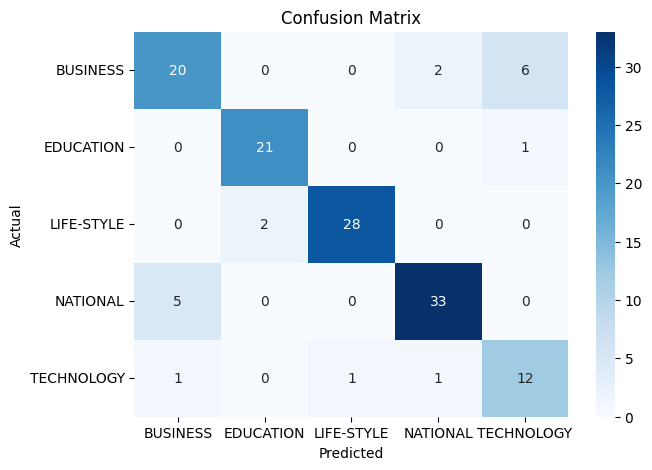

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true, preds)

plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
import torch

def predict_news_category(title, summary):
    # Combine training dataset
    text = title + " " + summary

    # Tokenize
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=128
    )

    # Put model in evaluation mode
    model.eval()

    with torch.no_grad():
        outputs = model(**inputs)

    # Get predicted class ID
    predicted_label_id = torch.argmax(outputs.logits, dim=1).item()

    # Convert number back to label name
    predicted_label = le.inverse_transform([predicted_label_id])[0]

    return predicted_label


In [ ]:
predict_news_category(
    "Sensex rises 350 points amid global market optimism",
    "Investors reacted positively to corporate earnings and global cues."
)


'BUSINESS'

In [ ]:
predict_news_category(
    "ISRO successfully tests new space propulsion system",
    "The breakthrough could enhance satellite maneuvering and deep-space missions."
)


'TECHNOLOGY'

In [ ]:
model.save_pretrained("/content/drive/MyDrive/PFA_Final_Project/news_classifier_model")
tokenizer.save_pretrained("/content/drive/MyDrive/PFA_Final_Project/news_classifier_model")


('/content/drive/MyDrive/PFA_Final_Project/news_classifier_model/tokenizer_config.json',
 '/content/drive/MyDrive/PFA_Final_Project/news_classifier_model/special_tokens_map.json',
 '/content/drive/MyDrive/PFA_Final_Project/news_classifier_model/spiece.model',
 '/content/drive/MyDrive/PFA_Final_Project/news_classifier_model/added_tokens.json',
 '/content/drive/MyDrive/PFA_Final_Project/news_classifier_model/tokenizer.json')

In [ ]:
import pickle

with open("/content/drive/MyDrive/PFA_Final_Project/label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)


Gradio

In [ ]:
!pip install gradio


In [ ]:
import gradio as gr


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import pickle

# Load saved model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/PFA_Final_Project/news_classifier_model")
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/PFA_Final_Project/news_classifier_model")

# Load label encoder
with open("/content/drive/MyDrive/PFA_Final_Project/label_encoder.pkl", "rb") as f:
    le = pickle.load(f)

model.eval()


AlbertForSequenceClassification(
  (albert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertSdpaAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=

In [ ]:
def classify_news(title, summary):
    text = title + " " + summary

    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=128
    )

    with torch.no_grad():
        outputs = model(**inputs)

    pred_id = torch.argmax(outputs.logits, dim=1).item()
    label = le.inverse_transform([pred_id])[0]

    return label


In [ ]:
import pandas as pd

def classify_csv(file):
    df = pd.read_csv(file.name)

    # Check required columns
    if not {"Title", "Summary"} <= set(df.columns):
        return "CSV must contain 'Title' and 'Summary' columns.", None

    predictions = []

    for i in range(len(df)):
        title = str(df.iloc[i]["Title"])
        summary = str(df.iloc[i]["Summary"])

        pred = classify_news(title, summary)
        predictions.append(pred)

    df["Predicted_Category"] = predictions

    # Save output CSV
    output_path = "/content/drive/MyDrive/PFA_Final_Project/predicted_results.csv"
    df.to_csv(output_path, index=False)

    return df, output_path


In [ ]:
custom_css = custom_css = """
/* Background Image */
.gradio-container {
    background: url('https://images.unsplash.com/photo-1507842217343-583bb7270b66?auto=format&fit=crop&w=1350&q=80') no-repeat center center fixed !important;
    background-size: cover !important;
    font-family: 'Poppins', sans-serif;
    position: relative;
    z-index: 1;
}

/* DARK OVERLAY BELOW UI */
.gradio-container::before {
    content: "";
    position: absolute;
    top: 0;
    left: 0;
    height: 100%;
    width: 100%;
    background: rgba(0,0,0,0.55);
    z-index: 1;
    pointer-events: none;
}

/* Bring UI components above overlay */
.gradio-container * {
    position: relative;
    z-index: 3;
    color: #4e2a0a !important; /* dark brown */
}

/* FORCE glowing heading */
.prose.svelte-ydeks8 h1,
h1.svelte-ydeks8,
.prose h1 {
    color: #ffffff !important;
    font-size: 48px !important;
    font-weight: 800 !important;
    text-align: center !important;

    text-shadow:
        0 0 10px rgba(255, 220, 160, 0.9),
        0 0 20px rgba(255, 180, 90, 0.8),
        0 0 40px rgba(255, 150, 50, 0.7),
        0 0 60px rgba(255, 120, 30, 0.6);

    animation: headingGlow 2.5s infinite alternate ease-in-out;
}

@keyframes headingGlow {
    from {
        text-shadow:
            0 0 6px rgba(255, 220, 160, 0.7),
            0 0 14px rgba(255, 180, 90, 0.6),
            0 0 25px rgba(255, 150, 50, 0.4);
    }
    to {
        text-shadow:
            0 0 12px rgba(255, 240, 200, 1),
            0 0 28px rgba(255, 200, 120, 0.9),
            0 0 45px rgba(255, 160, 80, 0.7),
            0 0 70px rgba(255, 140, 60, 0.6);
    }
}



/* Typing animation */
.typing {
    width: 100%;
    border-right: 3px solid white;
    white-space: nowrap;
    overflow: hidden;
    animation: typing 4s steps(30), blink 0.75s step-end infinite;
}
@keyframes typing {
    from { width: 0 }
    to   { width: 100% }
}
@keyframes blink {
    from, to { border-color: transparent }
    50% { border-color: white }
}



/* BUTTONS — Bronze Gradient */
button {
    background: linear-gradient(90deg, #b38752, #84592c) !important;
    color: #fff7e6 !important;
    font-weight: bold !important;
    border-radius: 12px !important;
    padding: 10px 20px !important;
    font-size: 17px !important;
}
button:hover {
    transform: scale(1.05);
    background: linear-gradient(90deg, #c99a60, #966736) !important;
}

label, .gr-label, .form label {
    color: #e6cba8 !important;  /* soft light brown */
    font-weight: 700 !important;
    font-size: 18px !important;
}

/* Footer */
.footer {
    margin-top: 20px;
    text-align: center;
    color: #f2f2f2;
    font-size: 16px;
    font-weight: 600;
    text-shadow: 1px 1px 2px black;
}

/* ========================= */
/* CUSTOM BROWN TAB COLORS   */
/* ========================= */

.gradio-tabs {
    background: transparent !important;
}

/* Tab text white */
.gradio-tabs .tabitem span {
    color: white !important;
}
/* Gradient brown input boxes */
input[type='text'], textarea {
    background: linear-gradient(180deg, rgba(214,180,138,0.25), rgba(180,140,95,0.30)) !important;
    border: 2px solid #b38752 !important;
    border-radius: 12px !important;
    padding: 12px !important;
    font-size: 16px !important;
    color: white !important; /* keeps text readable */
    backdrop-filter: blur(4px);
}


/* Selected tab (brown gradient) */
.gradio-tabs .tabitem.selected {
    background: linear-gradient(90deg, #b38752, #84592c) !important;
    border-radius: 10px !important;
    border-bottom: none !important;
}

/* Tab hover */
.gradio-tabs .tabitem:hover {
    background: rgba(255, 255, 255, 0.12) !important;
    border-radius: 10px !important;
}



.block-label:hover {
    box-shadow: 0 0 10px rgba(214,180,138,0.6);
}

span[class^="svelte-"][data-testid="block-info"] {
    background-color: rgba(214,180,138,0.40) !important;  /* light brown background */
    color: #4e2a0a !important;                            /* dark brown text */
    padding: 6px 12px !important;
    border-radius: 8px !important;
    border: 1px solid #b38752 !important;                 /* bronze border */
    font-weight: 700 !important;
    font-size: 16px !important;
    box-shadow: 0 0 6px rgba(0,0,0,0.25);
}

label.svelte-j0zqjt.float,
label.svelte-j0zqjt,
label[class*="svelte-"].float {
    background-color: rgba(214,180,138,0.40) !important;  /* light brown bg */
    color: #4e2a0a !important;                             /* dark brown text */
    padding: 6px 12px !important;
    border-radius: 8px !important;
    border: 1px solid #b38752 !important;                  /* bronze border */
    font-weight: 700 !important;
    font-size: 18px !important;
    box-shadow: 0 0 6px rgba(0,0,0,0.25);
}



/* --- FIX UPLOAD CSV DRAG-DROP BOX --- */
button.svelte-edrmkl.center.boundedheight.flex {
    background: rgba(240, 220, 190, 0.35) !important;  /* soft light beige */
    border: 2px solid #b38752 !important;              /* bronze border */
    border-radius: 15px !important;
    backdrop-filter: blur(4px);
    padding: 20px !important;
}

/* Text inside the upload box */
button.svelte-edrmkl.center.boundedheight.flex * {
    color: #4e2a0a !important;
    font-weight: 600 !important;
}

/* Upload SVG icon (arrow) */
button.svelte-edrmkl.center.boundedheight.flex svg {
    stroke: #4e2a0a !important;
}

/* Selected TAB underline color override */
button.svelte-i00v67.selected::after {
    background: linear-gradient(90deg, #b38752, #84592c) !important; /* bronze gradient */
    height: 4px !important;  /* adjust thickness */
    bottom: -2px !important;
    border-radius: 2px;
}

label[for*="file-download"] + div {
    background: linear-gradient(180deg, #ecd7bd, #d6b48a) !important;
    border: 2px solid #b38752 !important;
    border-radius: 14px !important;
    padding: 20px !important;
    backdrop-filter: blur(4px);
}
/* Force dark-brown typing text inside Gradio textboxes */
.input-container div,
.input-container .svelte-1ae7ssi,
.input-container *:not(input):not(textarea) {
    color: #5a3b15 !important;               /* dark brown */
}

.input-container input {
    caret-color: #5a3b15 !important;
}

/* FORCE white color for animated typing text */
.typing {
    color: #ffffff !important;
    text-shadow: 0 0 4px rgba(0,0,0,0.6) !important;
}

/* FORCE white color for Gradio's prose wrapper */
div.prose.svelte-ydeks8,
div.prose.svelte-ydeks8 * {
    color: #ffffff !important;
    text-shadow: 0 0 4px rgba(0,0,0,0.6) !important;
}

/* === SLIGHTLY STRONGER SOFT GLOW FOR YOUR H1 === */

.prose.svelte-ydeks8 h1,
div.prose.svelte-ydeks8 h1,
.prose h1 {
    color: #ffffff !important;
    text-align: center !important;
    font-size: 52px !important;
    font-weight: 900 !important;
    line-height: 1.15 !important;

    /* ✨ Medium–Soft Glow */
    text-shadow:
        0 0 6px rgba(255, 210, 160, 0.75),
        0 0 12px rgba(255, 180, 120, 0.55),
        0 0 20px rgba(255, 150, 90, 0.35) !important;

    animation: softGlow 3s ease-in-out infinite alternate !important;
}

@keyframes softGlow {
    from {
        text-shadow:
            0 0 6px rgba(255, 210, 160, 0.75),
            0 0 12px rgba(255, 180, 120, 0.55),
            0 0 20px rgba(255, 150, 90, 0.35);
    }
    to {
        text-shadow:
            0 0 10px rgba(255, 220, 180, 0.9),
            0 0 18px rgba(255, 190, 140, 0.7),
            0 0 28px rgba(255, 160, 100, 0.5);
    }
}



"""



# ------------------ ANIMATED DESCRIPTION ------------------
animated_description = """
<div class="typing" style="color:white; font-size:20px; margin-bottom:15px;">
This AI model predicts the category of any news article instantly...
</div>
"""

footer_html = """
<div class="footer">
Project by <b>Ishleen Kaur</b> (Roll No: <b>80025340021</b>)
</div>
"""


# ------------------ FULL GRADIO APP WITH TABS ------------------
with gr.Blocks(css=custom_css, theme=gr.themes.Soft()) as demo:

    gr.HTML("<h1>CateX</h1>")
    gr.HTML(animated_description)
    gr.HTML(footer_html)

    with gr.Tabs():

        # ------- TAB 1: MANUAL INPUT -------
        with gr.TabItem("Manual Prediction"):
            title_input = gr.Textbox(label="News Title")
            summary_input = gr.Textbox(label="News Summary", lines=5)
            output_label = gr.Label(label="Predicted Category")
            button = gr.Button("Predict")
            button.click(classify_news, [title_input, summary_input], output_label)

        # ------- TAB 2: CSV UPLOAD -------
        with gr.TabItem("📁 Upload CSV"):
            csv_file = gr.File(label="Upload CSV (must contain Title & Summary)")
            csv_output_table = gr.DataFrame(label="Results Preview")
            csv_download = gr.File(label="Download Result CSV")

            csv_button = gr.Button("Process CSV")
            csv_button.click(
                classify_csv,
                inputs=csv_file,
                outputs=[csv_output_table, csv_download]
            )

demo.launch(debug=True)

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://1c392deb6c6dfb109a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://1c392deb6c6dfb109a.gradio.live
